In [154]:
import pandas as pd
import numpy as np
import os

cps_dir = '/home/brian/Documents/CPS/data/'

def binned_wage_calc(dfm):
    """Return BLS-styled binned median wage"""
    wage_var = 'RHRWAGE'
    wage_ranges = list(np.arange(0.25,300,0.5))
    if 'RWKWAGE' in dfm.keys():
        wage_var = 'RWKWAGE'
        wage_ranges = list(np.arange(1.25,3000,2.5))      
    dft = (dfm.sort_values(wage_var)
              .assign(WAGE_RANGE = (lambda x: pd.cut(x[wage_var], wage_ranges, 
                                           include_lowest=True)),
                      CS = lambda x: x['PWORWGT'].cumsum()))
    d = {}
    for pt in [('25th', 0.25), ('50th', 0.5), ('10th', 0.1)]:
        midpt = dft['PWORWGT'].sum() * pt[1]
        mid_interval = dft.iloc[(dft['CS']-midpt).abs().argsort()[:1]].WAGE_RANGE.values[0]

        wage_bins = list(dft['WAGE_RANGE'].unique())

        mi_loc = wage_bins.index(mid_interval)
        lowval = dft[dft['WAGE_RANGE'] == wage_bins[mi_loc-1]].iloc[-1].CS
        highval = dft[dft['WAGE_RANGE'] == wage_bins[mi_loc]].iloc[-1].CS

        d[pt[0]] = ((((midpt - lowval) / (highval - lowval)) * 0.5) + mid_interval.left)
    
    return(d)

In [155]:
cps_files = pd.Series([pd.to_datetime(file[:5], format='%b%y') 
                       for file in os.listdir(cps_dir) 
                       if file.endswith('.dat')])

dt_windows = [pd.date_range(end=mo, periods=12, freq='MS') 
                  for mo in cps_files.sort_values()[11:]]

years = list(set([file.year for file in cps_files]))

filter_cols = ['HRYEAR4', 'HRMONTH', 'RHRWAGE', 'PWORWGT']
query_str = 'RHRWAGE > 0 and AGE > 15 and STATE == "CA"'

cps_date = lambda x: pd.to_datetime(
    dict(year=x.HRYEAR4, month=x.HRMONTH, day=1))
df = pd.concat([
     (pd.read_feather(f'{cps_dir}/clean/cps{year}.ft', nthreads=3)
        .query(query_str)
        .filter(filter_cols)
        .assign(DATE = cps_date)
        .drop(['HRYEAR4', 'HRMONTH'], axis=1)) 
     for year in years])

data = pd.DataFrame()
for dw in dt_windows:
    med_wage = binned_wage_calc(df[df['DATE'].isin(dw)])
    for key in med_wage.keys():
        data.at[dw[-1], key] = med_wage[key]

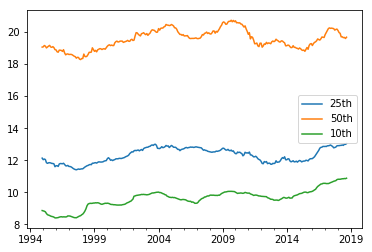

In [156]:
%matplotlib inline
data.plot()

In [148]:
data

,1994-12-01 00:00:00,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,...,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00
25th,25th,25th,25th,25th,25th,25th,25th,25th,25th,25th,...,25th,25th,25th,25th,25th,25th,25th,25th,25th,25th
50th,50th,50th,50th,50th,50th,50th,50th,50th,50th,50th,...,50th,50th,50th,50th,50th,50th,50th,50th,50th,50th
75th,75th,75th,75th,75th,75th,75th,75th,75th,75th,75th,...,75th,75th,75th,75th,75th,75th,75th,75th,75th,75th


In [126]:
data.loc['2017-12-01']

18.55870836074247

In [27]:
dt_windows

[DatetimeIndex(['1994-01-01', '1994-02-01', '1994-03-01', '1994-04-01',
                '1994-05-01', '1994-06-01', '1994-07-01', '1994-08-01',
                '1994-09-01', '1994-10-01', '1994-11-01', '1994-12-01'],
               dtype='datetime64[ns]', freq='MS'),
 DatetimeIndex(['1994-02-01', '1994-03-01', '1994-04-01', '1994-05-01',
                '1994-06-01', '1994-07-01', '1994-08-01', '1994-09-01',
                '1994-10-01', '1994-11-01', '1994-12-01', '1995-01-01'],
               dtype='datetime64[ns]', freq='MS'),
 DatetimeIndex(['1994-03-01', '1994-04-01', '1994-05-01', '1994-06-01',
                '1994-07-01', '1994-08-01', '1994-09-01', '1994-10-01',
                '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01'],
               dtype='datetime64[ns]', freq='MS'),
 DatetimeIndex(['1994-04-01', '1994-05-01', '1994-06-01', '1994-07-01',
                '1994-08-01', '1994-09-01', '1994-10-01', '1994-11-01',
                '1994-12-01', '1995-01-01', '1995-02